# Trabalho Prático Final
# Título aqui

### Thaís Ferreira da Silva - 2021092571

---
### OBS. para uma rápida execução, reduza o tamanho do dataframe utilizado na função **preprocess_data**
---

## Inicialização

In [47]:
#Imports para gráficos e manipulação de dados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import os

#Imports para aprendizado de máquina e PyTorch
import torch
from torch.nn.functional import binary_cross_entropy_with_logits

#Imports para transformers e Hugging Face
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments

#Imports para manipulação de dados e métricas
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score, recall_score

#Outros imports
import numpy as np
import warnings
from tqdm import tqdm

---
## Análise inicial dos dados e Pré-processamento

In [48]:
def treat_data(df):
    """
    Remove os 19 gêneros menos existentes das listas de gêneros de cada jogo
    e exclui jogos sem gêneros após a limpeza.
    """
    # Contar a frequência de cada gênero
    all_genres = [genre for sublist in df['Genres'] for genre in sublist]
    genre_counts = Counter(all_genres)

    # Identificar os 19 gêneros menos comuns
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1])
    least_common_genres = [genre for genre, count in sorted_genres[:19]]
    print("19 gêneros menos comuns identificados:", least_common_genres)

    # Remover os 19 gêneros menos comuns das listas de gêneros de cada jogo
    new_df = df.copy()
    new_df['Genres'] = new_df['Genres'].apply(lambda x: [genre for genre in x if genre not in least_common_genres])

    # Remover jogos que ficaram sem gênero após a limpeza
    new_df = new_df[new_df['Genres'].apply(len) > 0].reset_index(drop=True)

    #salvar no games_tratado.csv
    new_df.to_csv('data/games_tratado.csv', index=False)

    return new_df


In [49]:
# Verificar se o arquivo 'games_database.csv' já existe no diretório
if os.path.exists('data/games_database.csv'):
    # Se o arquivo existir, carregar o DataFrame do arquivo CSV
    df = pd.read_csv('data/games_database.csv')
    print("Arquivo 'games_database.csv' carregado.")
    
    # Remover aspas simples dos gêneros (se existirem)
    df['Genres'] = df['Genres'].apply(lambda x: [genre.replace("'", "") for genre in eval(x)] if isinstance(x, str) else x)

else:
    # Caso o arquivo não exista, criar e processar os dados
    df = pd.read_csv('data/games.csv')
    df = df[['AppID', 'About the game', 'Genres']]
    df = df.rename(columns={'AppID': 'Name'})

    # Dividindo os gêneros em listas e removendo as aspas simples
    df['Genres'] = df['Genres'].str.split(',')
    df['Genres'] = df['Genres'].apply(lambda x: [genre.replace("'", "") for genre in x] if isinstance(x, list) else [])

    # Salvar o DataFrame processado no arquivo
    df.to_csv('data/games_database.csv', index=False)
    print("Arquivo 'games_database.csv' criado e salvo.")

df.head()

Arquivo 'games_database.csv' criado e salvo.


,Name,About the game,Genres
20200,Galactic Bowling,Galactic Bowling is an exaggerated and stylize...,"[Casual, Indie, Sports]"
655370,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,"[Action, Indie]"
1732930,Jolt Project,Jolt Project: The army now has a new robotics ...,"[Action, Adventure, Indie, Strategy]"
1355720,Henosis™,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[Adventure, Casual, Indie]"
1139950,Two Weeks in Painland,ABOUT THE GAME Play as a hacker who has arrang...,"[Adventure, Indie]"


In [50]:
df_analise = df
df_pre_processed = treat_data(df)

19 gêneros menos comuns identificados: ['Documentary', 'Episodic', 'Tutorial', '360 Video', 'Movie', 'Short', 'Accounting', 'Sexual Content', 'Web Publishing', 'Nudity', 'Photo Editing', 'Software Training', 'Audio Production', 'Game Development', 'Gore', 'Video Production', 'Free To Play', 'Education', 'Animation & Modeling']


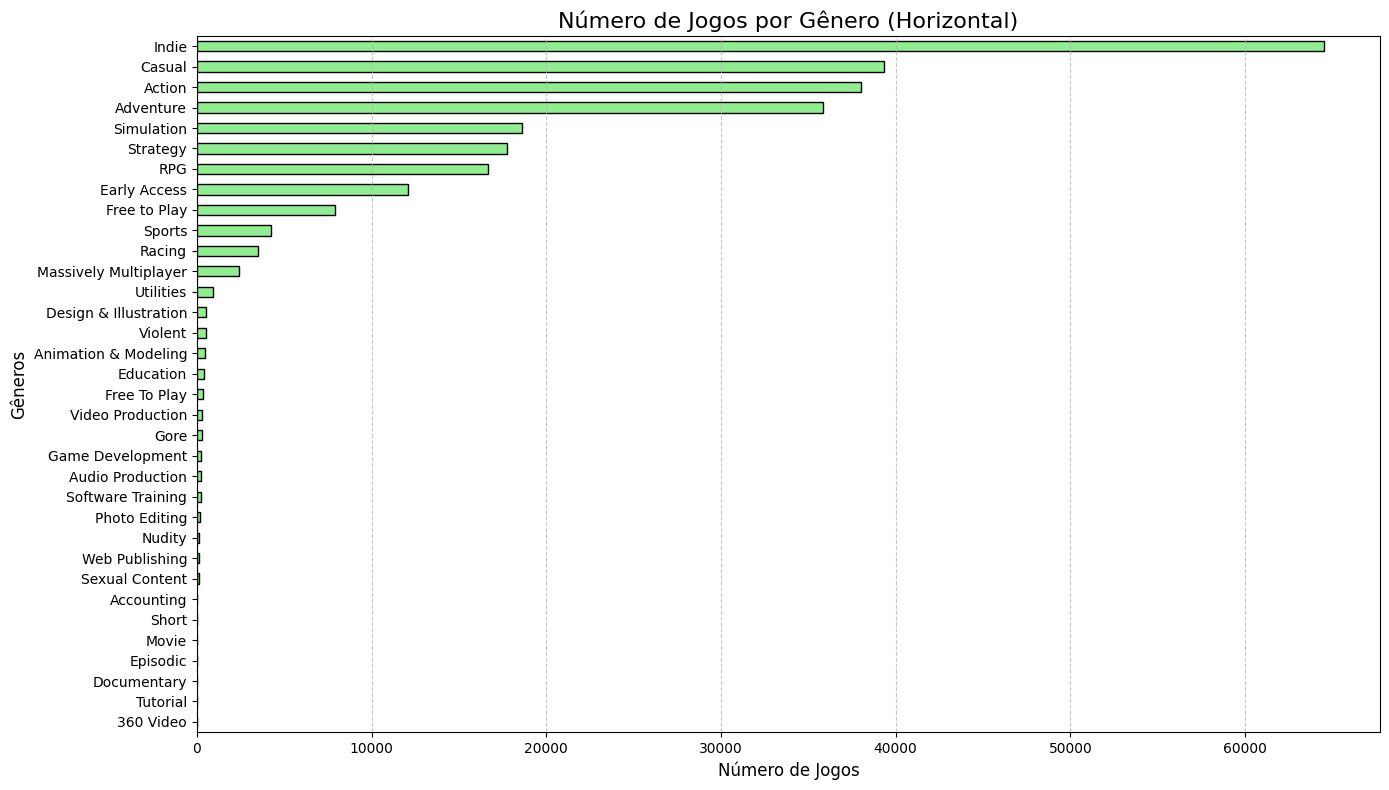

In [51]:
# Transformando cada gênero em uma linha separada
exploded_df = df_analise.explode('Genres')

# Contando o número de jogos por gênero
genre_counts = exploded_df['Genres'].value_counts()

# Plotando o gráfico de barras (horizontal) com a ordem invertida
plt.figure(figsize=(14, 8))
genre_counts[::-1].plot(kind='barh', color='lightgreen', edgecolor='black')
plt.title('Número de Jogos por Gênero (Horizontal)', fontsize=16)
plt.xlabel('Número de Jogos', fontsize=12)
plt.ylabel('Gêneros', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

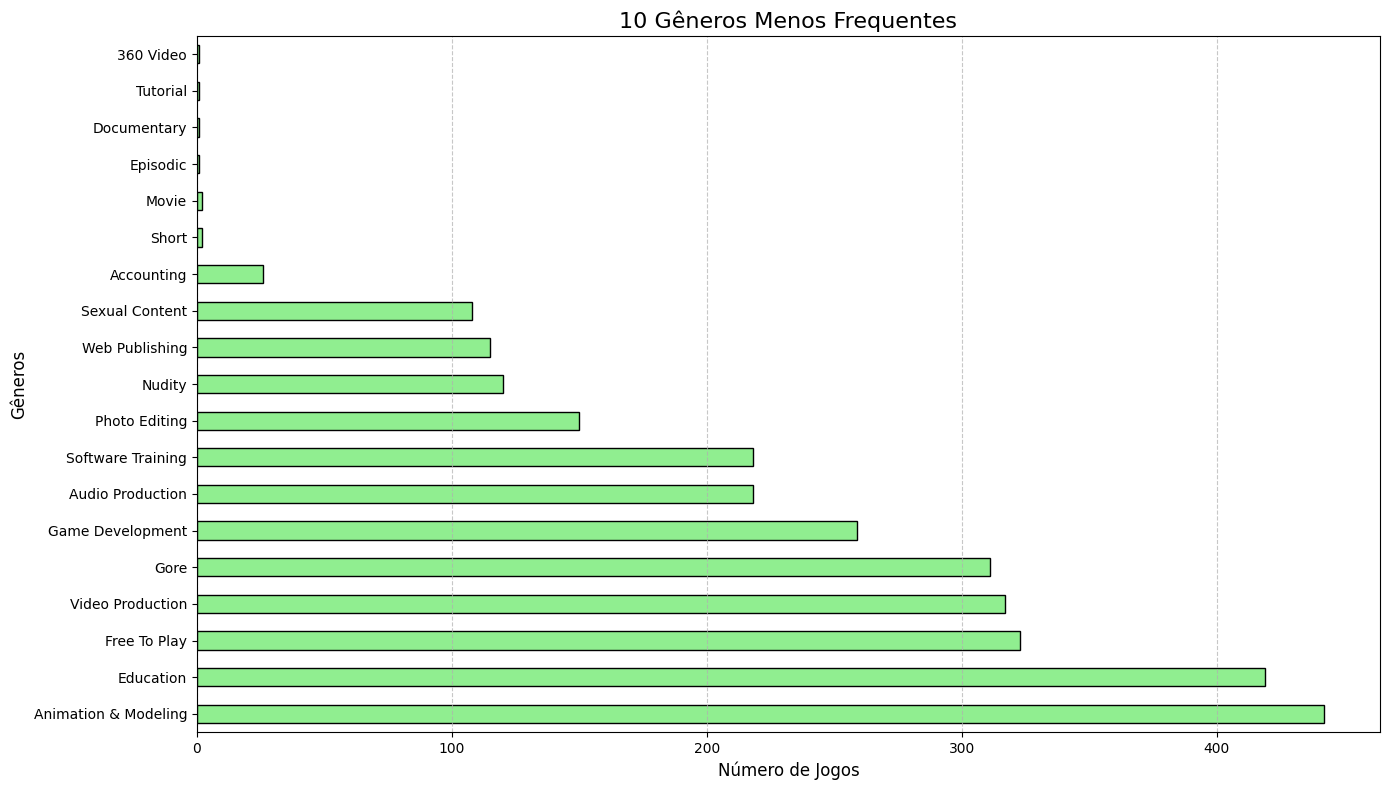

In [52]:
#plotar os 10 gêneros menos frequentes
plt.figure(figsize=(14, 8))
genre_counts[-19:].plot(kind='barh', color='lightgreen', edgecolor='black')
plt.title('10 Gêneros Menos Frequentes', fontsize=16)
plt.xlabel('Número de Jogos', fontsize=12)

plt.ylabel('Gêneros', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


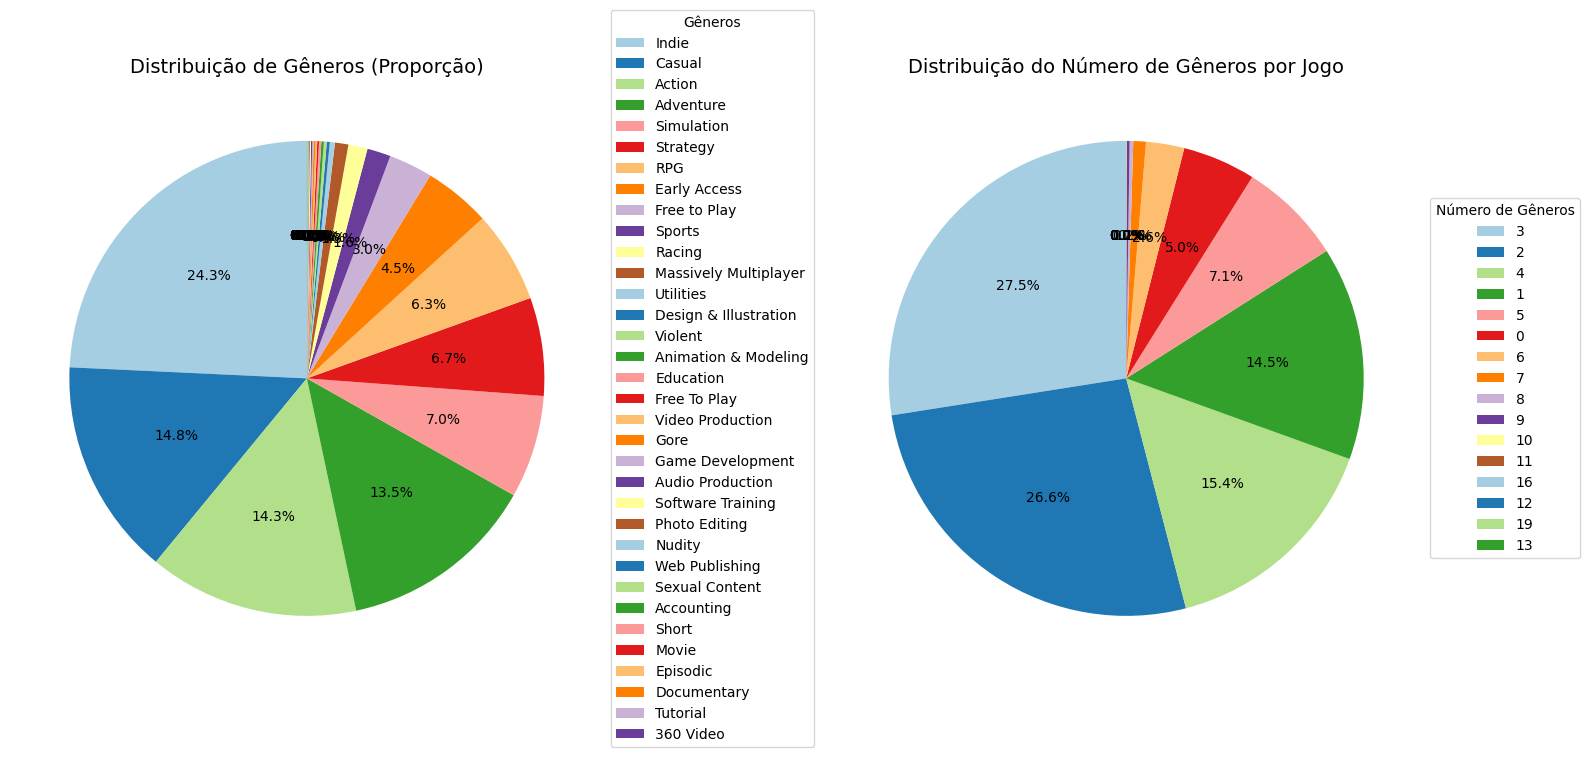

In [53]:
# Contando o número de gêneros por jogo
df_analise['Num_Genres'] = df_analise['Genres'].apply(len)

# Contando a distribuição do número de gêneros por jogo
num_genres_counts = df_analise['Num_Genres'].value_counts()

# Proporção de cada gênero
genre_proportion = genre_counts / genre_counts.sum()

# Criando os subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de pizza (Distribuição de Gêneros)
wedges1, texts1, autotexts1 = axes[0].pie(genre_proportion, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0].set_title('Distribuição de Gêneros (Proporção)', fontsize=14)
axes[0].set_ylabel('')  # Remover o rótulo do eixo y
axes[0].legend(wedges1, genre_proportion.index, title="Gêneros", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Gráfico de pizza (Distribuição do Número de Gêneros por Jogo)
wedges2, texts2, autotexts2 = axes[1].pie(num_genres_counts, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[1].set_title('Distribuição do Número de Gêneros por Jogo', fontsize=14)
axes[1].set_ylabel('')  # Remover o rótulo do eixo y
axes[1].legend(wedges2, num_genres_counts.index.astype(str), title="Número de Gêneros", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

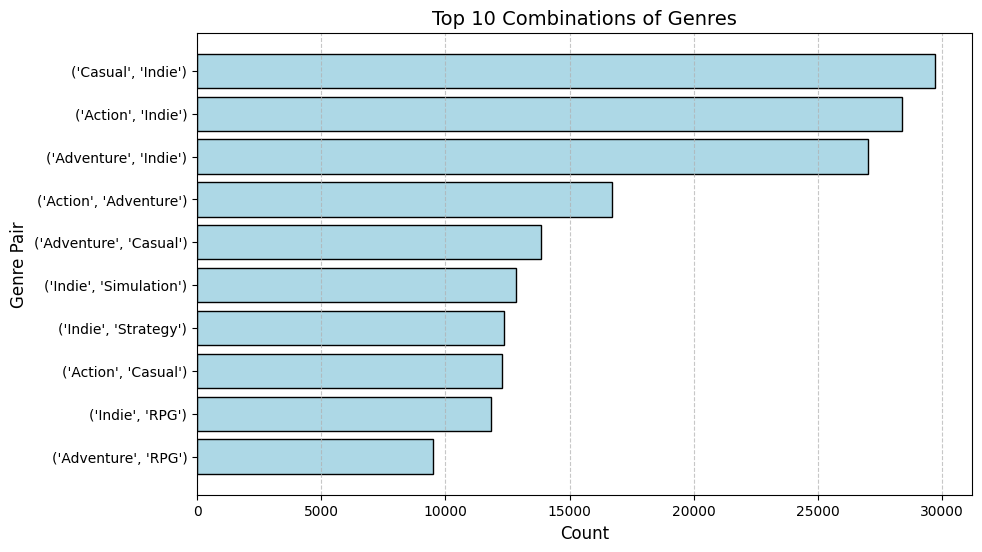

In [54]:
# Criando a lista de combinações de gêneros
genre_combinations = []
for genres in df_analise['Genres']:
    genre_combinations.extend(combinations(genres, 2))

# Contando a frequência das combinações
genre_pair_counts = Counter(genre_combinations)

# Convertendo para DataFrame e ordenando
genre_pairs_df = pd.DataFrame(genre_pair_counts.items(), columns=['Genre Pair', 'Count']).sort_values(by='Count', ascending=False)

# Selecionando as 10 combinações mais frequentes
top_combinations = genre_pairs_df.head(10)

# Criando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(top_combinations['Genre Pair'].astype(str), top_combinations['Count'], color='lightblue', edgecolor='black')
plt.title('Top 10 Combinations of Genres', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre Pair', fontsize=12)
plt.gca().invert_yaxis()  # Inverter a ordem para exibir a combinação mais frequente no topo
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

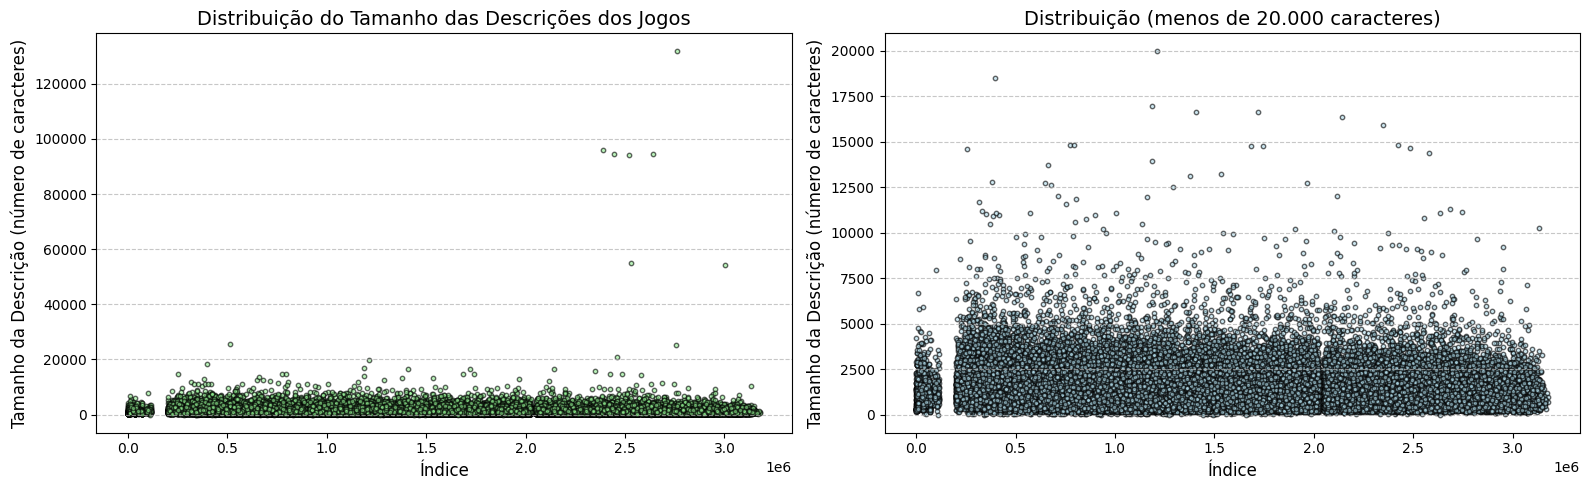

In [55]:
# Calculando o tamanho da descrição
df_analise['Description_Length'] = df_analise['About the game'].str.len()

# Criando os subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Primeiro gráfico (todos os dados)
axes[0].scatter(df_analise.index, df_analise['Description_Length'], color='lightgreen', edgecolor='black', alpha=0.6, s=10)
axes[0].set_title('Distribuição do Tamanho das Descrições dos Jogos', fontsize=14)
axes[0].set_xlabel('Índice', fontsize=12)
axes[0].set_ylabel('Tamanho da Descrição (número de caracteres)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Segundo gráfico (apenas valores menores que 20.000 caracteres)
filtered_data = df_analise[df_analise['Description_Length'] < 20000]
axes[1].scatter(filtered_data.index, filtered_data['Description_Length'], color='lightblue', edgecolor='black', alpha=0.6, s=10)
axes[1].set_title('Distribuição (menos de 20.000 caracteres)', fontsize=14)
axes[1].set_xlabel('Índice', fontsize=12)
axes[1].set_ylabel('Tamanho da Descrição (número de caracteres)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()




---
# Treinamento com o Bert

In [56]:
# Função para pré-processar os dados
def preprocess_data(file_path):
    """Carrega e pré-processa os dados."""
    df = pd.read_csv(file_path)
    df['Genres'] = df['Genres'].apply(lambda x: eval(x) if isinstance(x, str) else [])
    df = df.dropna(subset=['About the game', 'Genres'])
    return df.sample(n=40000, random_state=42) # Descomente esse pedaço para diminuir os dados utilizados e deixar mais rápido

# Função para tokenizar os textos
def tokenize_function(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Criar datasets para o treinamento
def create_hf_dataset(inputs, labels):
    # Verifique se todos os arrays têm o mesmo comprimento
    assert len(inputs['input_ids']) == len(inputs['attention_mask']) == len(labels), "Mismatch in data sizes"
    return Dataset.from_dict({
        "input_ids": inputs['input_ids'].tolist(),
        "attention_mask": inputs['attention_mask'].tolist(),
        "labels": labels.tolist()
    })

# Definir o modelo personalizado para classificação multi-label
class BertForMultiLabelClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super(BertForMultiLabelClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return logits
    
# Função para calcular métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Verifica se o número de amostras é o mesmo
    if logits.shape[0] != labels.shape[0]:
        min_samples = min(logits.shape[0], labels.shape[0])
        logits = logits[:min_samples]
        labels = labels[:min_samples]

    # Converte logits em previsões binárias (0 ou 1)
    predictions = (logits > 0).astype(int)
    
    # Cálculo das métricas
    f1 = f1_score(labels, predictions, average='micro')
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')

    # Penalizar mais os falsos positivos
    false_positives = ((predictions == 1) & (labels == 0)).sum()
    false_positives_penalty = false_positives * 2  # Aumente o multiplicador para penalizar mais
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "false_positive_penalty": false_positives_penalty
    }
# Subclasse personalizada de Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(torch.float32)  # Converte labels para float32
        outputs = model(**inputs)  # Obtém os logits do modelo
        logits = outputs

        # Calcula a perda usando BCEWithLogitsLoss
        loss = binary_cross_entropy_with_logits(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [57]:
# Configurações iniciais

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # SO FUNCIONA COM NVIDEA
print(f"Usando dispositivo: {device}")

data_path = "./data/games_tratado.csv"

# Carregar os dados
df = preprocess_data(data_path)

Usando dispositivo: cpu


In [58]:
# Codificar os gêneros como multi-label
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['Genres'])

# Divisão dos dados
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['About the game'], genre_labels, test_size=0.4, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.80, random_state=42  
)

# Verificar tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {len(train_texts)}")
print(f"Tamanho do conjunto de validação: {len(val_texts)}")
print(f"Tamanho do conjunto de teste: {len(test_texts)}")
print('-------------------------------------------------------------')
print('Número de gêneros únicos:', len(mlb.classes_))
print('Gêneros:', mlb.classes_)

Tamanho do conjunto de treino: 24000
Tamanho do conjunto de validação: 3200
Tamanho do conjunto de teste: 12800
-------------------------------------------------------------
Número de gêneros únicos: 15
Gêneros: ['Action' 'Adventure' 'Casual' 'Design & Illustration' 'Early Access'
 'Free to Play' 'Indie' 'Massively Multiplayer' 'RPG' 'Racing'
 'Simulation' 'Sports' 'Strategy' 'Utilities' 'Violent']


In [59]:
# Inicializar o tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

train_dataset = create_hf_dataset(train_encodings, train_labels)
val_dataset = create_hf_dataset(val_encodings, val_labels)
test_dataset = create_hf_dataset(test_encodings, test_labels)


In [60]:
num_labels = len(mlb.classes_)
model = BertForMultiLabelClassification("bert-base-uncased", num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
# Configurar o treinamento
training_args = TrainingArguments(
    output_dir="./training_output",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    weight_decay=0.01,
    num_train_epochs=1,
    logging_dir="./training_output/log",
    save_total_limit=2,
    logging_steps=10,
    fp16=False
)

# Criar o Trainer personalizado
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Avaliar o modelo
trainer.train()

Step,Training Loss,Validation Loss,F1,Precision,Recall,False Positive Penalty
50,0.358000,0.351841,0.429162,0.597491,0.334832,3914
100,0.329400,0.315841,0.457818,0.552945,0.390618,5480
150,0.312800,0.299077,0.462125,0.495256,0.433149,7660
200,0.295100,0.288834,0.454790,0.496656,0.419433,7376
250,0.291100,0.283868,0.448578,0.491221,0.412748,7418
300,0.286900,0.280791,0.450360,0.497353,0.411480,7216
350,0.293400,0.279213,0.453925,0.491275,0.421853,7580


TrainOutput(global_step=375, training_loss=0.3165778137842814, metrics={'train_runtime': 3395.0473, 'train_samples_per_second': 7.069, 'train_steps_per_second': 0.11, 'total_flos': 0.0, 'train_loss': 0.3165778137842814, 'epoch': 1.0})

---
## Predição dos gêneros

In [62]:
# Função para prever gêneros
def predict_genres(description, model, tokenizer, mlb, device, threshold=0.5):
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    # Remove token_type_ids se estiver presente
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model(**inputs)  # outputs já é um tensor
    
    probs = torch.sigmoid(outputs).cpu().numpy()  # Aplicar sigmoid diretamente
    predictions = (probs > threshold).astype(int)
    predicted_genres = mlb.inverse_transform(predictions)
    
    return predicted_genres[0]


In [63]:
# Suprimir mensagens de UserWarning relacionadas ao sklearn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Inicializar listas para armazenar os resultados
game_names = []
predicted_genres_list = []
real_genres_list = []
all_precisions = []
all_recalls = []
all_f1_scores = []

# Inicializar contadores para métricas por gênero
genre_metrics = {
    "True Positives": {genre: 0 for genre in mlb.classes_},
    "False Positives": {genre: 0 for genre in mlb.classes_},
    "False Negatives": {genre: 0 for genre in mlb.classes_},
    "True Negatives": {genre: 0 for genre in mlb.classes_},
}

# Configurar tqdm para barra de progresso
with tqdm(total=len(val_dataset), desc="Processando jogos", unit="jogo", ncols=100, leave=True, dynamic_ncols=True) as pbar:
    for i in range(len(val_dataset)):
        game_name = df.iloc[i]["Name"]
        description = df.iloc[i]["About the game"]

        genres = df.iloc[i]["Genres"]
        if isinstance(genres, str):
            genres = [genre.strip() for genre in genres.split(",")]
        else:
            genres = [genre.strip() for genre in genres]

        # Prever os gêneros
        predicted_genres = predict_genres(description, model, tokenizer, mlb, device)

        # Transformar para one-hot encoding
        true_labels = mlb.transform([genres])[0]  
        predicted_labels = mlb.transform([predicted_genres])[0]

        # Calcular métricas
        precision, recall, f1, _ = precision_recall_fscore_support(
            [true_labels], [predicted_labels], average="micro", zero_division=0
        )

        # Atualizar contadores de métricas por gênero
        for genre in mlb.classes_:
            idx = mlb.classes_.tolist().index(genre)
            if true_labels[idx] == 1 and predicted_labels[idx] == 1:
                genre_metrics["True Positives"][genre] += 1
            elif true_labels[idx] == 0 and predicted_labels[idx] == 1:
                genre_metrics["False Positives"][genre] += 1
            elif true_labels[idx] == 1 and predicted_labels[idx] == 0:
                genre_metrics["False Negatives"][genre] += 1
            elif true_labels[idx] == 0 and predicted_labels[idx] == 0:
                genre_metrics["True Negatives"][genre] += 1

        # Armazenar resultados
        game_names.append(game_name)
        predicted_genres_list.append(", ".join(predicted_genres))  # Converter lista para string formatada
        real_genres_list.append(", ".join(genres))  # Converter lista para string formatada
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1_scores.append(f1)

        pbar.update(1)

# Criar DataFrame com os resultados
df_results_complete = pd.DataFrame({
    "Game Name": game_names,
    "Predicted Genres": predicted_genres_list,
    "Real Genres": real_genres_list,
    "Precision": all_precisions,
    "Recall": all_recalls,
    "F1-Score": all_f1_scores
})


Processando jogos: 100%|██████████| 3200/3200 [04:56<00:00, 10.81jogo/s]


---
# Analise dos resultados

In [64]:
# Salvar o DataFrame no arquivo CSV
df_results_complete.to_csv('resultados_analise_completa.csv', index=False)
print("Resultados salvos em 'resultados_analise_completa.csv'.")

# Exibir métricas globais
print("\nResultados Globais:")
print("Média de Precision:", np.mean(all_precisions))
print("Média de Recall:", np.mean(all_recalls))
print("Média de F1-Score:", np.mean(all_f1_scores))

# Coletar dados de True Negatives para o gráfico
true_negatives = []
for genre in mlb.classes_:
    true_negatives.append(genre_metrics["True Negatives"].get(genre, 0))

Resultados salvos em 'resultados_analise_completa.csv'.

Resultados Globais:
Média de Precision: 0.7354635416666667
Média de Recall: 0.6805775049603174
Média de F1-Score: 0.6663243371212121


In [65]:
df_results_complete.head()

,Game Name,Predicted Genres,Real Genres,Precision,Recall,F1-Score
0,Conquest of Elysium 5,"Indie, Strategy","Indie, Strategy",1.000000,1.0,1.000000
1,Tipsy Rescue,"Casual, Indie",Indie,0.500000,1.0,0.666667
2,NAGARE-BOSHI,"Casual, Indie","Casual, Indie",1.000000,1.0,1.000000
3,Beauty Jigsaw,"Casual, Indie","Casual, Indie",1.000000,1.0,1.000000
4,The Warriorlock,"Adventure, Indie, RPG","Adventure, Casual, RPG, Strategy",0.666667,0.5,0.571429


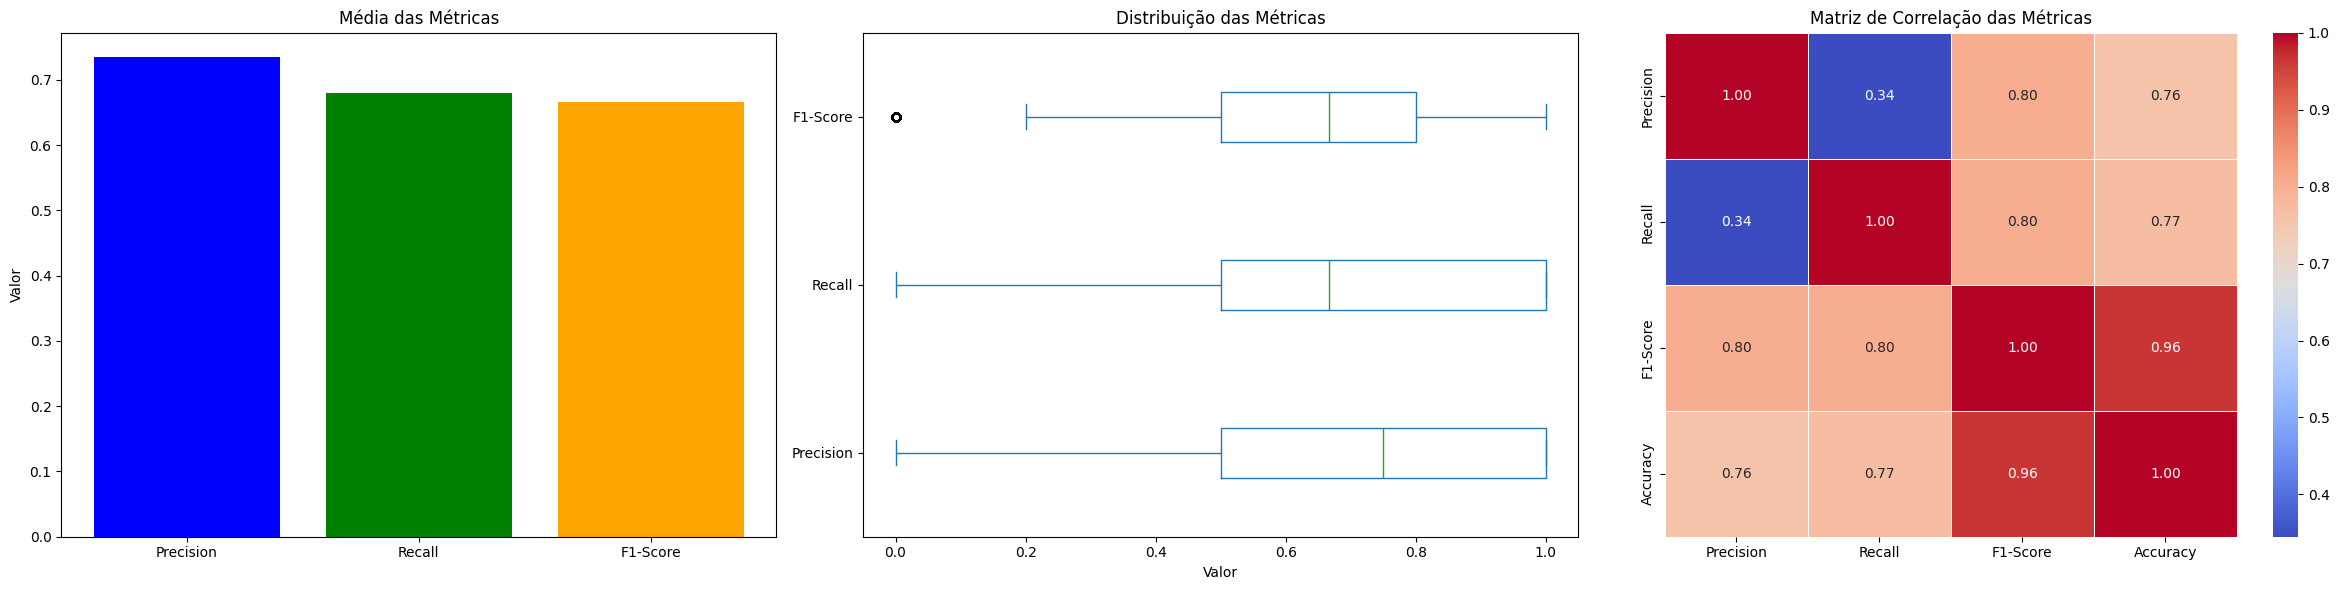

In [66]:
# Plotando as médias globais, a distribuição das métricas e a matriz de correlação lado a lado
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 linha e 3 colunas

# Gráfico da média das métricas
metrics = ['Precision', 'Recall', 'F1-Score']
values = [np.mean(all_precisions), np.mean(all_recalls), np.mean(all_f1_scores)]

axes[0].bar(metrics, values, color=['blue', 'green', 'orange'])
axes[0].set_title('Média das Métricas')
axes[0].set_ylabel('Valor')

# Gráfico da distribuição das métricas (boxplot)
metrics_df = pd.DataFrame({
    'Precision': all_precisions,
    'Recall': all_recalls,
    'F1-Score': all_f1_scores
})

metrics_df.plot(kind='box', vert=False, ax=axes[1])
axes[1].set_title('Distribuição das Métricas')
axes[1].set_xlabel('Valor')

# Adicionando as métricas ao DataFrame para visualização
df_results_complete['Accuracy'] = df_results_complete['Precision'] * df_results_complete['Recall']

# Calcular a correlação
correlation_matrix = df_results_complete[['Precision', 'Recall', 'F1-Score', 'Accuracy']].corr()

# Gráfico da matriz de correlação (heatmap)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axes[2])
axes[2].set_title('Matriz de Correlação das Métricas')

plt.tight_layout()
plt.show()

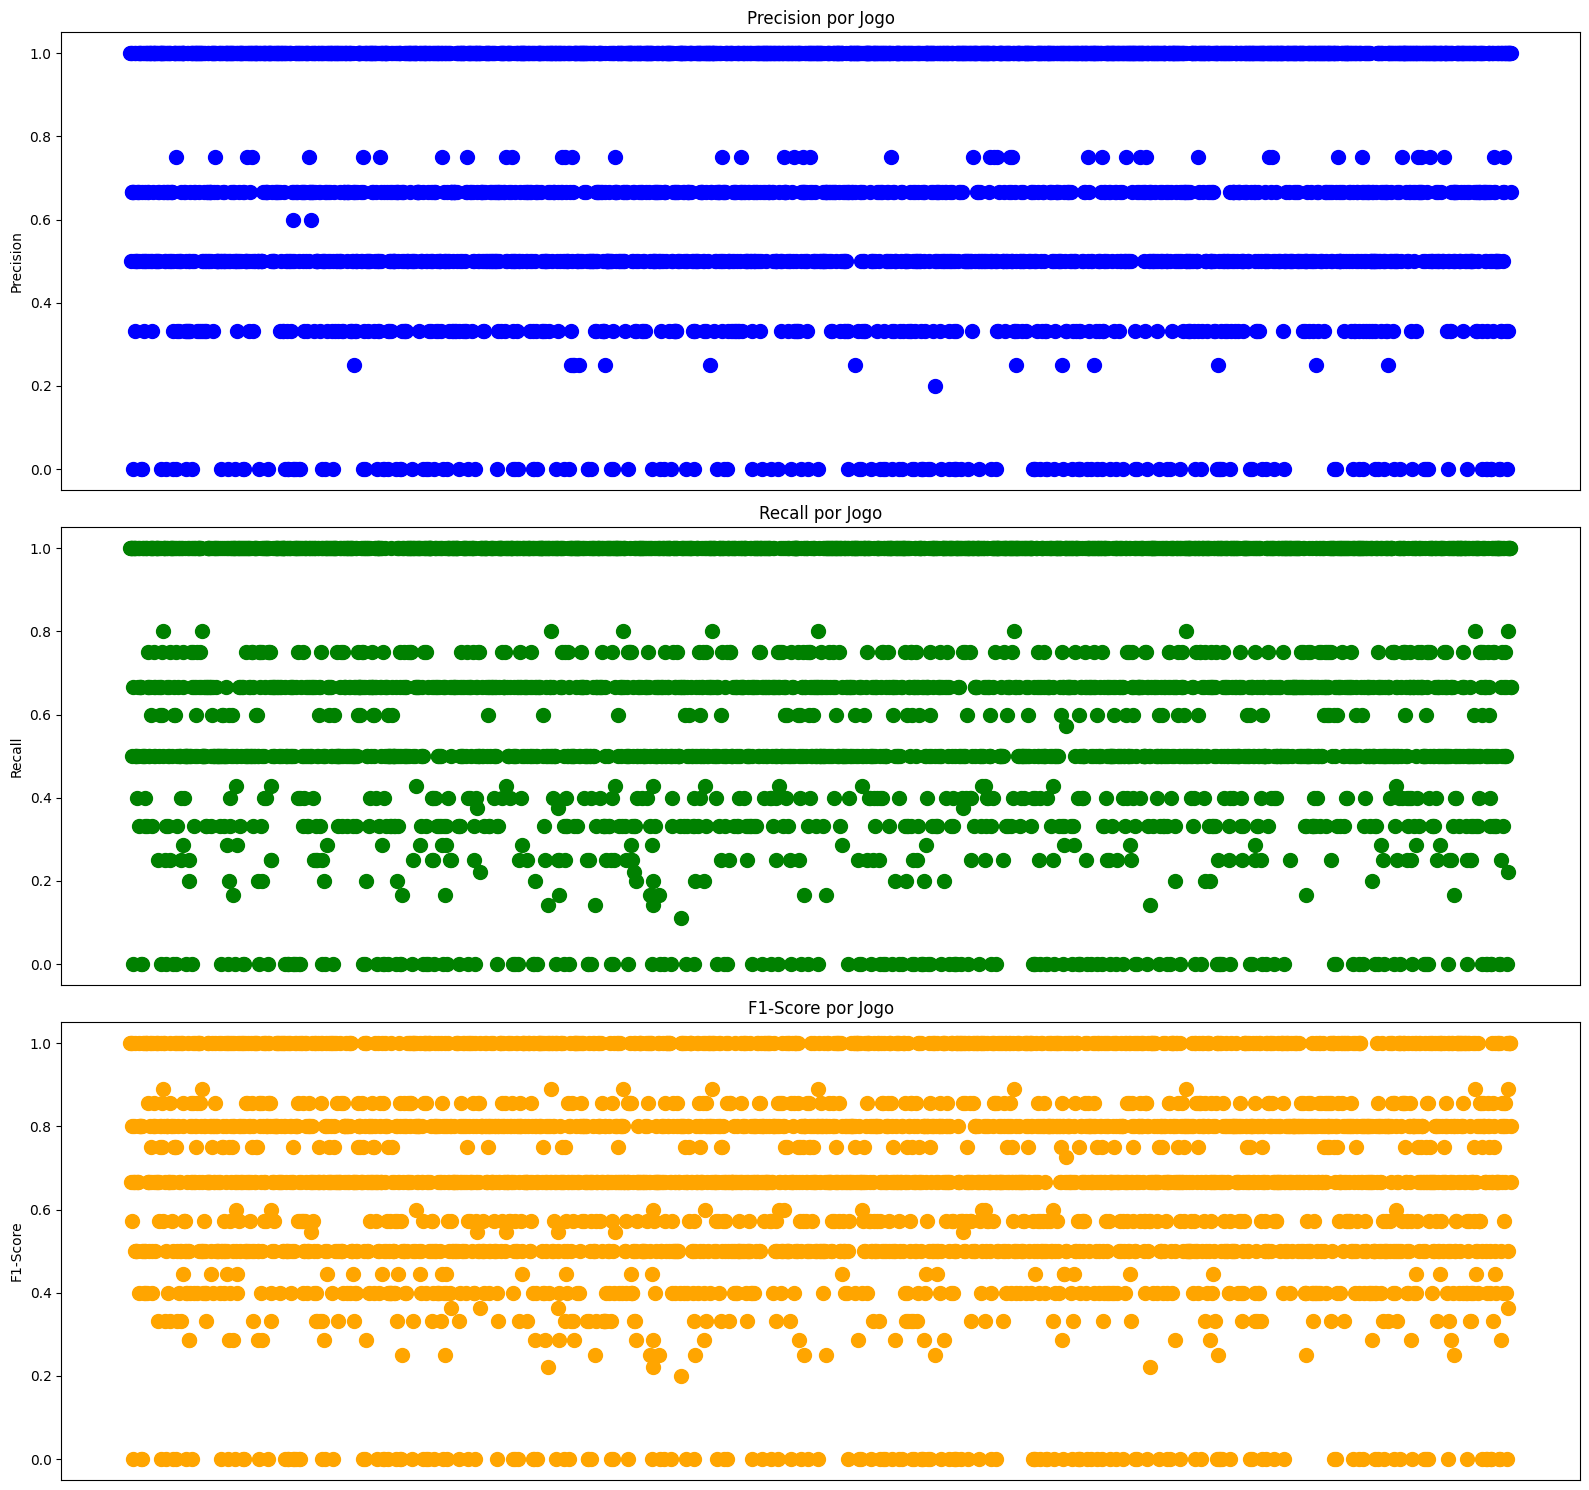

In [67]:
# Plotando gráficos de Precision, Recall e F1-Score para cada jogo
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

# Índices dos jogos
game_indices = range(len(df_results_complete))

# Gráfico de Precision
axes[0].scatter(game_indices, df_results_complete["Precision"], color='blue', label='Precision', s=100)
axes[0].set_title('Precision por Jogo')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Gráfico de Recall
axes[1].scatter(game_indices, df_results_complete["Recall"], color='green', label='Recall', s=100)
axes[1].set_title('Recall por Jogo')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Gráfico de F1-Score
axes[2].scatter(game_indices, df_results_complete["F1-Score"], color='orange', label='F1-Score', s=100)
axes[2].set_title('F1-Score por Jogo')
axes[2].set_ylabel('F1-Score')
axes[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.show()




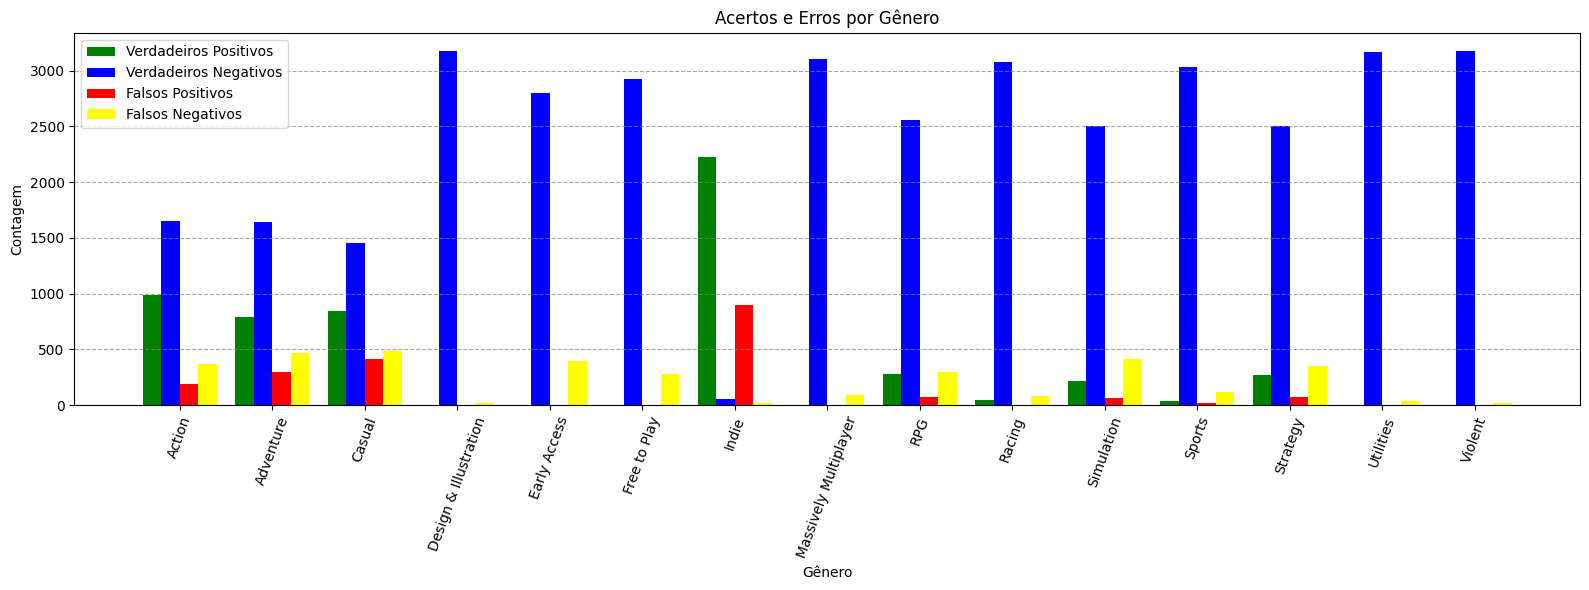

In [68]:
# Preparar dados para o gráfico de barras
true_positives = []
true_negatives = []  # True Negatives primeiro
false_positives = []
false_negatives = []  # False Negatives depois

for genre in mlb.classes_:
    true_positives.append(genre_metrics["True Positives"].get(genre, 0))
    true_negatives.append(genre_metrics["True Negatives"].get(genre, 0))  # Capturando True Negatives
    false_positives.append(genre_metrics["False Positives"].get(genre, 0))
    false_negatives.append(genre_metrics["False Negatives"].get(genre, 0))  # Capturando False Negatives

# Plotando o gráfico de barras verticais
fig, ax = plt.subplots(figsize=(16, 6))

bar_width = 0.2
index = range(len(mlb.classes_))

# Ajustar a ordem das barras: True Positives & True Negatives, depois False Positives & False Negatives
ax.bar([i - 1.5 * bar_width for i in index], true_positives, bar_width, label='Verdadeiros Positivos', color='green')
ax.bar([i - 0.5 * bar_width for i in index], true_negatives, bar_width, label='Verdadeiros Negativos', color='blue')  # True Negatives primeiro

ax.bar([i + 0.5 * bar_width for i in index], false_positives, bar_width, label='Falsos Positivos', color='red')
ax.bar([i + 1.5 * bar_width for i in index], false_negatives, bar_width, label='Falsos Negativos', color='yellow')  # False Negatives depois

# Ajustes dos rótulos e título
ax.set_xlabel('Gênero')
ax.set_ylabel('Contagem')
ax.set_title('Acertos e Erros por Gênero')
ax.set_xticks(index)  # Gêneros no eixo x
ax.set_xticklabels(mlb.classes_, rotation=70)  # Rotacionando os nomes dos gêneros

ax.legend()

# Adicionando grid horizontal
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()
